In [14]:
import numpy as np
import math
from scipy.stats import norm
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy.stats import unitary_group
import random
# import concurrent.futures
import multiprocessing
import os
from scipy import stats

from mpl_toolkits import mplot3d
import scipy.integrate as spi

Introduction:

In [15]:
M =1
mu = 0
rho_q = 1
rho_a = 1
########Teta
sigma_teta = 1#(1/math.sqrt(2))
real_teta = np.random.normal(mu, sigma_teta,M)
im_teta = np.random.normal(mu, sigma_teta,M)
teta = real_teta #+ 1j*im_teta
teta = teta.reshape(M,1)

In [16]:
def Matrix(na,nq): #new model
    H_mat = np.zeros((na*M,M), complex)
    G_mat = np.zeros((nq*M,M), complex)
    for i in range(0,na*M,M):
        if M>1:
            H_mat[i:M+i,:] = math.sqrt(rho_a)*unitary_group.rvs(M)
        else:
            x1 = random.random()
            y1 = math.sqrt(1 - pow(x1, 2))
            H_mat[i:M + i, :] = math.sqrt(rho_a)*(x1+1j*y1)
    for i in range(0,nq*M,M):
        if M > 1:
            G_mat[i:M+i,:] = math.sqrt(rho_q)*unitary_group.rvs(M)
        else:
            x2 = random.random()
            y2 = np.sqrt(1 - np.power(x2, 2))
            G_mat[i:M + i, :] = math.sqrt(rho_a)*(x2 + 1j * y2)
    return H_mat, G_mat

In [17]:
def thresh_G(n_q, Mat):
    if M>1:
        G_teta=Mat@((mu+1j*mu)*np.ones(M))
    else:
        G_teta=Mat*((mu+1j*mu)*np.ones(M))
    return G_teta.real.reshape(M*n_q, 1), G_teta.imag.reshape(M*n_q, 1)

In [18]:
def x(sigma1,sigma2, n_a,n_q, matrix,theta=teta,thresh_real=0,thresh_im=0): #the observations- function of teta
    sigma_w_a = sigma1 * (1 / math.sqrt(2))
    real_w_a = np.random.normal(mu, sigma_w_a, M*n_a)
    im_w_a = np.random.normal(mu, sigma_w_a, M*n_a)
    w_a = real_w_a + 1j * im_w_a
    w_a = w_a.reshape(M*n_a, 1)

    sigma_w_q = sigma2 * (1 / math.sqrt(2))
    real_w_q = np.random.normal(mu, sigma_w_q, M*n_q)
    im_w_q = np.random.normal(mu, sigma_w_q, M*n_q)
    w_q = real_w_q + 1j * im_w_q
    w_q = w_q.reshape(M*n_q, 1)

    if M>1:
        x_a = matrix[0]@theta+w_a
        y = matrix[1]@theta+w_q
    else:
        x_a = matrix[0]*theta+w_a
        y = matrix[1]*theta+w_q

    x_q = (1/math.sqrt(2))*(np.sign(y.real-(thresh_real))+1j*np.sign(y.imag-((thresh_im))))
    return x_a.reshape(M*n_a,), x_q.reshape(M*n_q,)

In [19]:
def samp(sigma1,sigma2, n_a,n_q, matrix, observ,thresh_real=0,thresh_im=0): #samples
    real_teta_samp = np.random.normal(mu, sigma_teta, (M,observ))
    im_teta_samp = np.random.normal(mu, sigma_teta, (M,observ))
    teta_samp = (real_teta_samp + 1j*im_teta_samp)

    sigma_w_a_samp = sigma1 * (1 / math.sqrt(2))
    real_w_a_samp = np.random.normal(mu, sigma_w_a_samp, (M*n_a,observ))
    im_w_a_samp = np.random.normal(mu, sigma_w_a_samp, (M*n_a,observ))
    w_a_samp = (real_w_a_samp + 1j * im_w_a_samp)

    sigma_w_q_samp = sigma2* (1 / math.sqrt(2))
    real_w_q_samp = np.random.normal(mu, sigma_w_q_samp,(M*n_q,observ))
    im_w_q_samp = np.random.normal(mu, sigma_w_q_samp,(M*n_q,observ))
    w_q_samp = (real_w_q_samp + 1j * im_w_q_samp)

    x_a_samp = (matrix[0]@teta_samp)+w_a_samp
    y_samp = (matrix[1]@teta_samp) + w_q_samp

    x_q_samp = (1/math.sqrt(2))*(np.sign(y_samp.real-(thresh_real))+(1j*(np.sign(y_samp.imag-((thresh_im))))))
    return x_a_samp, x_q_samp, teta_samp

In [20]:
def samp_teta(observ): #samples-for CRB function (d_k)
    real_teta_samp = np.random.normal(mu, sigma_teta, (M, observ))
    im_teta_samp = np.random.normal(mu, sigma_teta, (M, observ))
    teta_samp = real_teta_samp + 1j * im_teta_samp
    return  teta_samp.reshape(M,observ)

In [21]:
def covariance(v1,v2):
    normv1 = np.mean(v1,1)
    normv2 = np.mean(v2,1)
    v = v1-normv1.reshape(np.shape(v1)[0],1)
    u = v2 -normv2.reshape(np.shape(v2)[0],1)
    result = [v[:,i].reshape(np.shape(v)[0], 1)@u[:,i].conjugate().transpose().reshape(1, np.shape(u)[0]) for i in range(np.shape(v)[1])]
    return np.sum(result,0)/(np.shape(v)[1]-1)

Main work:

In [22]:
def MSE_general_numerical(sigma1,sigma2, n_a,n_q, matrix, observ, epsilon=0.1, thresh_real=0,thresh_im=0):
    cov = np.zeros((observ, M, M))
    cov_teta_xa = matrix[0].transpose().conjugate()
    x_a_vec, x_q_vec, teta_vec = samp(sigma1,sigma2, n_a,n_q, matrix,int(5e4),thresh_real,thresh_im)
    cov_teta_xq = covariance(teta_vec,x_q_vec)
    inv_A = (np.identity(M*n_a)-((1/(rho_a*n_a+pow(sigma1,2)))*(matrix[0]@matrix[0].transpose().conjugate())))/pow(sigma1,2) #Na X Na
    B = covariance(x_a_vec,x_q_vec) #Na X Nq
    C = B.conjugate().transpose() #Nq X Na, B.conjugate().transpose()
    D = covariance(x_q_vec,x_q_vec) #np.cov(x_q_vec) #Nq X Nq
    K = D-C@inv_A@B
    if np.linalg.det(K) == 0: #check if K is singular
        U,S,V = np.linalg.svd(K)
        S[S<epsilon] = epsilon
        K = U@np.diag(S)@V #K+epsilon*np.identity(K.shape[0])
    inv_K = LA.inv(K)
    cov_x_inv_up =np.concatenate((inv_A+(inv_A@B@inv_K@C@inv_A), -1*(inv_A@B@inv_K)),axis=1)
    cov_x_inv_down = np.concatenate((-1*(inv_K@C@inv_A), inv_K),axis=1)
    cov_x_inv = np.concatenate((cov_x_inv_up,cov_x_inv_down),axis=0)
    cov_teta_x = np.concatenate((cov_teta_xa, cov_teta_xq),axis=1)
    for i in range(observ):
        real_teta = np.random.normal(mu, sigma_teta,M)
        im_teta = np.random.normal(mu, sigma_teta,M)
        teta = real_teta + 1j*im_teta
        teta = teta.reshape(M,1)
        mu_tilda_real = mu*(np.sum(matrix[1].real,axis=1)-np.sum(matrix[1].imag,axis=1))
        mu_tilda_imag = mu*(np.sum(matrix[1].real,axis=1)+np.sum(matrix[1].imag,axis=1))
        sigma_tilda = 1+(np.sum(np.power(matrix[1].real,2),axis=1)+np.sum(np.power(matrix[1].imag,2),axis=1))
        p1 = norm.cdf(np.divide(np.subtract(thresh_real,mu_tilda_real.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))
        p2 = norm.cdf(np.divide(np.subtract(thresh_im,mu_tilda_imag.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))

        x_a, x_q = x(sigma1,sigma2, n_a, n_q, matrix,teta,thresh_real,thresh_im) #the actually observations
        x_a_vec_norm = x_a-matrix[0]@((mu+1j*mu)*np.ones(M))#np.mean(x_a)*np.ones((np.shape(x_a)))
        x_q_vec_norm = x_q.reshape(M*n_q,1)-math.sqrt(2)*((1-2*p1)+1j*(1-2*p2))#np.mean(x_q)*np.ones((M*n_q,1))
        x_vec_norm = np.concatenate((x_a_vec_norm, x_q_vec_norm.reshape(M*n_q,)), axis=0)

        teta_hat = (cov_teta_x@cov_x_inv@x_vec_norm) +(mu+1j*mu)*np.ones(M)
        cov[i,:,:] = ((teta_hat-teta)@((teta_hat-teta).conjugate().T)).real #m>1, real number
        #cov[i,:,:] = ((teta_hat-teta)*(teta_hat-teta).conjugate()).real #M=1, real number
    cov_matrix = np.sum(cov,0)/(np.shape(cov)[0])
    return LA.norm(cov_matrix, "fro")#M>1 np.squeeze(cov_matrix) #M=1

In [23]:
def MSE_zertothresh_analytic(sigma1,sigma2, n_a,n_q):
    alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma2, 2)))
    beta = ((1-alpha)/rho_q)-((2*rho_a*n_a)/(math.pi*(rho_q+pow(sigma2,2))*(rho_a*n_a+pow(sigma1,2))))
    first = (rho_a*n_a)/(rho_a*n_a+pow(sigma1, 2))
    second = (2*rho_q*n_q*pow(sigma1,4))/(math.pi*(rho_q+pow(sigma2, 2))*(alpha+beta*rho_q*n_q)*pow(rho_a*n_a+pow(sigma1, 2),2))
    return M*(1-first-second)

def MSE_biglaw(sigma1,sigma2, n_a, n_q, matrix, observ,thresh_real=0,thresh_im=0):
    MSE = np.zeros((observ, M, M))
    for i in range(observ):
        real_teta = np.random.normal(mu, sigma_teta,M)
        im_teta = np.random.normal(mu, sigma_teta,M)
        teta = real_teta + 1j*im_teta
        teta = teta.reshape(M,1)
        x_a, x_q = x(sigma1,sigma2, n_a, n_q, matrix,teta,thresh_real,thresh_im)  # function of teta
        alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma2, 2)))
        C = (2 * rho_q * rho_a * n_a) / (math.pi * (rho_q + pow(sigma2, 2)) * (rho_a * n_a + pow(sigma1, 2)))
        w_q = (pow(sigma1, 2) / (pow(sigma1, 2) + (rho_a * n_a))) * (
                    (alpha + (1 - alpha) * n_q) / (alpha + ((1 - alpha - C) * n_q)))
        w_a = 1 - ((2 * rho_q * n_q * w_q) / (math.pi * (rho_q + pow(sigma2, 2)) * (alpha + (1 - alpha) * n_q)))
        teta_a_hat = (1 / ((rho_a * n_a) + pow(sigma1, 2))) * ((matrix[0].conjugate().T) @ (x_a))
        teta_q_hat = math.sqrt(2 / (math.pi * (rho_q + pow(sigma2, 2)))) * (1 / (alpha + ((1 - alpha) * n_q)))*((matrix[1].conjugate().T) @ (x_q))
        teta_hat = (w_q * teta_q_hat) +(w_a * teta_a_hat)
        MSE[i, :, :] = ((teta_hat - teta)@((teta_hat - teta).conjugate().T)).real
    cov_matrix = np.mean(MSE, 0)
    return LA.norm(cov_matrix, "fro")

In [41]:
sim = 10
na = 2
nq = 40
sigma_space_new = np.logspace(-1,1,20)
matrix_const = Matrix(na,nq)


L_Estimator_biglaw = [MSE_biglaw(sigma_space_new[i],sigma_space_new[i], na, nq, matrix_const, sim) for i in range(len(sigma_space_new))]
L_Estimator_numerical1 = [MSE_general_numerical(sigma_space_new[i],sigma_space_new[i], na,nq, matrix_const, sim) for i in range(len(sigma_space_new))]
L_Estimator_analytic = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na, nq) for i in range(len(sigma_space_new))]
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_biglaw, color = "green", label = "Analytic")
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_numerical1, color = "black", label = "Numerical")
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic, color = "red", label = "Analytic2")
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

KeyboardInterrupt: 

In [32]:
def CRB(sigma1,sigma2, n_a,n_q,matrix, quantize=1,observ=sim,thresh_real=0,thresh_im=0):
    teta_samp = samp_teta(observ)
    g_teta = matrix[1] @ teta_samp
    G_normal = matrix[1]/math.sqrt(n_q*rho_q)
    zeta_real = ((math.sqrt(2)/sigma2)*(g_teta.real-thresh_real))
    zeta_im = ((math.sqrt(2)/sigma2)*(g_teta.imag-thresh_im))
    pdf_real = norm.pdf(zeta_real)
    cdf_real = norm.cdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    cdf_im = norm.cdf(zeta_im)
    # d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
    #         np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d = np.mean(d_vec, axis=1) #converges to 0.95 aprox.
    if quantize == 0:
        J2 = (2/math.pi)*(rho_q * n_q / pow(sigma2, 2))*np.identity(M)
    else:
        my_vector = [(n_q*rho_q*d[i])*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
        J2 = np.sum(my_vector,axis=0)*(1/(2*pow(sigma2, 2)))
    J1 = (1 + (rho_a * n_a / pow(sigma1, 2))) * np.identity(M)
    J = J1 + J2

    my_vector = [((2*pow(sigma1,2)*pow(sigma2,2))+(2*rho_a*n_a*pow(sigma2,2))+n_q*rho_q*d[i]*pow(sigma1,2))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    J_sum = np.sum(my_vector,axis=0)*(1/(2*pow(sigma2, 2)*pow(sigma1,2)))
    # my_vector = [(((2 * pow(sigma2, 2))) /((2*pow(sigma1,2)*pow(sigma2,2))+(2*rho_a*n_a*pow(sigma2,2))+n_q*rho_q*d[i]*pow(sigma1,2)))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    # Bound_sum = np.sum(my_vector,axis=0) #Harder to compute
    return LA.norm((LA.inv(J)).real,"fro")#LA.norm((LA.inv(J_sum)).real,"fro"), , LA.norm((LA.inv(J1)).real,"fro"), LA.norm((LA.inv(J2+np.identity(M))).real,"fro")

def CRB_pp(sigma1,sigma2, n_a,n_q,matrix, observ=sim,thresh_real=0,thresh_im=0):
    teta_samp = samp_teta(observ)
    g_teta = matrix[1] @ teta_samp
    G_normal = matrix[1]/math.sqrt(n_q*rho_q)
    zeta_real = ((math.sqrt(2)/sigma2)*(g_teta.real-thresh_real))
    zeta_im = ((math.sqrt(2)/sigma2)*(g_teta.imag-thresh_im))
    pdf_real = norm.pdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)

    J2_vec = np.mean(((pdf_real+pdf_im)*matrix[1]),1)
    J2 = (1/(pow(sigma2,2)))*J2_vec.transpose().conjugate()@J2_vec
    J1 = (1 + (rho_a * n_a / pow(sigma1, 2))) * np.identity(M)
    J = J1 + J2

    return LA.norm((LA.inv(J)).real,"fro")

In [40]:
def proba(sigma1,sigma2, n_a,matrix,xa,xq,theta,thresh_real=0,thresh_im=0):
    zeta_real = ((math.sqrt(2)/sigma2)*(matrix[1]@theta.real-thresh_real))
    zeta_im = ((math.sqrt(2)/sigma2)*(matrix[1]@theta.imag-thresh_im))
    p_theta = 1/(pow(math.pi,M))*np.exp(-np.linalg.norm (theta)**2)
    f_xa = 1/(pow((sigma1**2)*math.pi,M*n_a))*np.exp(-(np.linalg.norm (xa-matrix[0]@theta)**2)/(sigma1**2))
    f_xq = np.prod(np.pow(norm.cdf(zeta_real),0.5+xq.real/math.sqrt(2)),1)*np.prod(np.pow(norm.cdf(zeta_im),0.5+xq.imag/math.sqrt(2)),1)\
    *np.prod(np.pow(norm.cdf(-zeta_real),0.5-xq.real/math.sqrt(2)),1)*np.prod(np.pow(norm.cdf(-zeta_im),0.5-xq.imag/math.sqrt(2)),1)
    return p_theta*f_xq*f_xa

observ = 100
na, nq = 1,40
const = Matrix(na,nq)
xa,xq,theta = samp(1,1, 1,40, const, observ)
#proba(1,1, 2,const,xa,xq,theta)

In [26]:
def bounds(sigma1,sigma2, n_a,n_q,matrix, quantize=1,observ=sim,thresh_real=0,thresh_im=0):
    teta_samp = samp_teta(observ)
    g_teta = matrix[1] @ teta_samp
    G_normal = matrix[1]/math.sqrt(n_q*rho_q)
    zeta_real = ((math.sqrt(2)/sigma2)*(g_teta.real-thresh_real))
    zeta_im = ((math.sqrt(2)/sigma2)*(g_teta.imag-thresh_im))
    pdf_real = norm.pdf(zeta_real)
    cdf_real = norm.cdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    cdf_im = norm.cdf(zeta_im)
    # d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
    #         np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d = np.mean(d_vec, axis=1) #converges to 0.95 aprox.
    if quantize == 0:
        J2 = (2/math.pi)*(rho_q * n_q / pow(sigma2, 2))*np.identity(M)
    else:
        my_vector = [(n_q*rho_q*d[i])*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
        J2 = np.sum(my_vector,axis=0)*(1/(2*pow(sigma2, 2)))



    J1 = np.identity(M)+WWS_a
    J = J1 + J2

    my_vector = [((2*pow(sigma1,2)*pow(sigma2,2))+(2*rho_a*n_a*pow(sigma2,2))+n_q*rho_q*d[i]*pow(sigma1,2))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    J_sum = np.sum(my_vector,axis=0)*(1/(2*pow(sigma2, 2)*pow(sigma1,2)))
    # my_vector = [(((2 * pow(sigma2, 2))) /((2*pow(sigma1,2)*pow(sigma2,2))+(2*rho_a*n_a*pow(sigma2,2))+n_q*rho_q*d[i]*pow(sigma1,2)))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    # Bound_sum = np.sum(my_vector,axis=0) #Harder to compute
    return LA.norm((LA.inv(J)).real,"fro")#LA.norm((LA.inv(J_sum)).real,"fro"), , LA.norm((LA.inv(J1)).real,"fro"), LA.norm((LA.inv(J2+np.identity(M))).real,"fro")

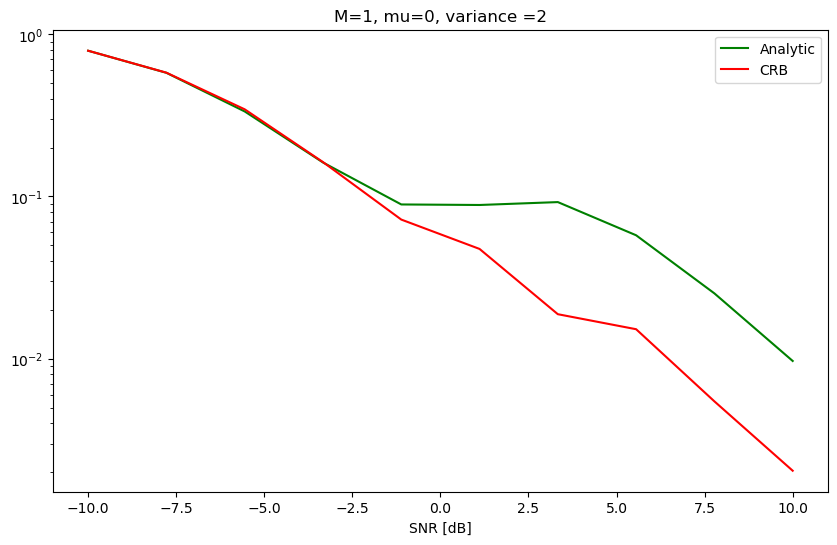

In [27]:
sim = 1e3
na = 1
nq = 40
epsilon = pow(10,-1)
sigma_space_new = np.logspace(-1,1,10)
matrix_const = Matrix(na,nq)
L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na,nq) for i in range(len(sigma_space_new))]
CRB1 = [CRB(sigma_space_new[i],sigma_space_new[i],na,nq,matrix_const) for i in range(len(sigma_space_new))]
#CRB_pp1 = [CRB_pp(sigma_space_new[i],sigma_space_new[i],na,nq,matrix_const) for i in range(len(sigma_space_new))]
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic1, color = "green", label = "Analytic")
plt.plot(10*np.log10(1/sigma_space_new), CRB1, color = "red", label = "CRB")
#plt.plot(10*np.log10(1/sigma_space_new), CRB_pp1, color = "blue", label = "CRB_*")
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

Make sure my proof of J_quntize is fine:

In [232]:
# def CRB_try(sigma2, n_q,matrix, observ):
#     teta_samp = samp_teta(observ)
#     G = matrix
#     g_teta = G@teta_samp
#     G_normal = matrix/math.sqrt(n_q*rho_q)
#
#     zeta_real = (math.sqrt(2) / sigma2 * (g_teta.real))
#     zeta_im = (math.sqrt(2) / sigma2 * (g_teta.imag))
#     pdf_real = norm.pdf(zeta_real)
#     cdf_real = norm.cdf(zeta_real)
#     pdf_im = norm.pdf(zeta_im)
#     cdf_im = norm.cdf(zeta_im)
#     d_vec = np.divide(np.power(pdf_real, 2), np.multiply(cdf_real, (norm.cdf(-zeta_real)))) + \
#             np.divide(np.power(pdf_im, 2), np.multiply(cdf_im, (norm.cdf(-zeta_im))))
#     d = np.mean(d_vec, axis=1) #converges to 0.95 aprox.
#
#     my_vector1 = [(d[i])*G[i].reshape(M,1).conjugate()*G[i].reshape(M,1).transpose() for  i in range(len(d))]
#     my_vector2 = [(n_q*rho_q*d[i])*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
#
#     J1 = np.sum(my_vector1,axis=0)*(1/(2*pow(sigma2, 2)))
#     J2 = np.sum(my_vector2,axis=0)*(1/(2*pow(sigma2, 2)))
#     J3 = (G.transpose().conjugate()@np.diag(d)@G)*(1/(2*pow(sigma2, 2)))
#     J4 = (G_normal.transpose().conjugate()@np.diag(d)@G_normal)*((rho_q*n_q)/(2*pow(sigma2, 2)))
#
#     # my_vector = [(((2 * pow(sigma2, 2))) /((2*pow(sigma1,2)*pow(sigma2,2))+(2*rho_a*n_a*pow(sigma2,2))+n_q*rho_q*d[i]*pow(sigma1,2)))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
#     # Bound_sum = np.sum(my_vector,axis=0) #Harder to compute
#
#     return LA.norm((LA.inv(J1)).real,"fro"), LA.norm((LA.inv(J2)).real,"fro"),LA.norm((LA.inv(J3)).real,"fro"),LA.norm((LA.inv(J4)).real,"fro")
#
# na = 2
# nq = 40
# sim = 100
# sigma_space_new = np.logspace(-1,1,15)
# epsilon = pow(10,-1)
# matrix_const = Matrix(na,nq)[1]
# CRB = [CRB_try(sigma_space[i],nq,matrix_const,sim) for i in range(len(sigma_space_new))]
# CRB = np.array(CRB)
# print(CRB[:,0])
# print("====================================")
# print(CRB[:,1])
# print("====================================")
# print(CRB[:,2])
# print("====================================")
# print(CRB[:,3])

ValueError: setting an array element with a sequence.

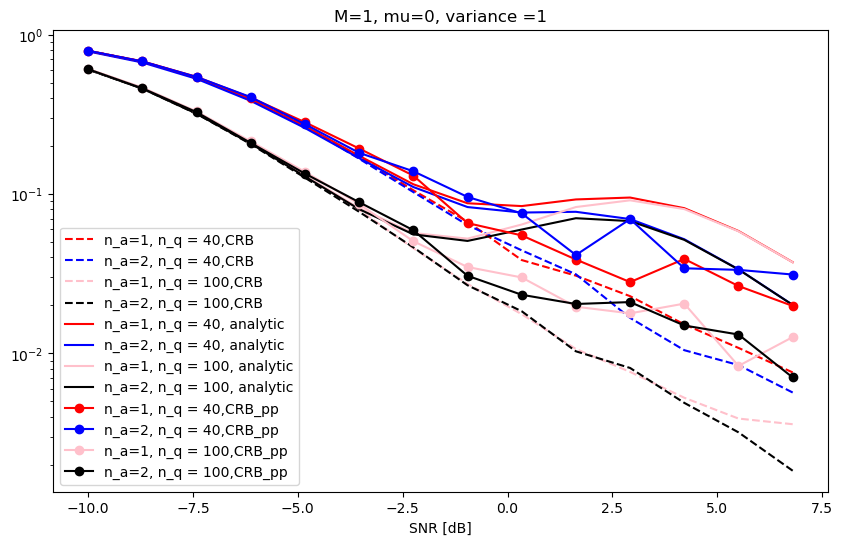

In [21]:
sigma_space = np.logspace(-0.68,1,14)
n_a = [1,2,1,2]
n_q = [40,40,100,100]
epsilon = pow(10,-1)
matrix_const1 = Matrix(n_a[0],n_q[0])
matrix_const2 = Matrix(n_a[1],n_q[1])
matrix_const3 = Matrix(n_a[2],n_q[2])
matrix_const4 = Matrix(n_a[3],n_q[3])
sim = 300
thresh_real = thresh_G(n_q[0],matrix_const1[1])[0]
thresh_imag = thresh_G(n_q[0],matrix_const1[1])[1]
thresh_const = np.ones((M*n_q[0], 1))

L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[0],n_q[0]) for i in range(len(sigma_space))]
L_Estimator_analytic2 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[1],n_q[1]) for i in range(len(sigma_space))]
L_Estimator_analytic3 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[2],n_q[2]) for i in range(len(sigma_space))]
L_Estimator_analytic4 = [MSE_zertothresh_analytic(sigma_space[i],sigma_space[i], n_a[3],n_q[3]) for i in range(len(sigma_space))]

CRB1 = [CRB(sigma_space[i],sigma_space[i],n_a[0],n_q[0],matrix_const1) for i in range(len(sigma_space))]
CRB2 = [CRB(sigma_space[i],sigma_space[i],n_a[0],n_q[1],matrix_const2) for i in range(len(sigma_space))]
CRB3 = [CRB(sigma_space[i],sigma_space[i],n_a[2],n_q[2],matrix_const3) for i in range(len(sigma_space))]
CRB4 = [CRB(sigma_space[i],sigma_space[i],n_a[3],n_q[3],matrix_const4) for i in range(len(sigma_space))]

CRBpp1 = [CRB_pp(sigma_space[i],sigma_space[i],n_a[0],n_q[0],matrix_const1) for i in range(len(sigma_space))]
CRBpp2 = [CRB_pp(sigma_space[i],sigma_space[i],n_a[0],n_q[1],matrix_const2) for i in range(len(sigma_space))]
CRBpp3 = [CRB_pp(sigma_space[i],sigma_space[i],n_a[2],n_q[2],matrix_const3) for i in range(len(sigma_space))]
CRBpp4 = [CRB_pp(sigma_space[i],sigma_space[i],n_a[3],n_q[3],matrix_const4) for i in range(len(sigma_space))]
######################
fig = plt.figure(figsize=(10, 6))
list_of_colors = ['red','blue','pink','black']
list_of_functions = [CRB1,CRB2,CRB3,CRB4]

for i in range(len(list_of_functions)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions[i],'--' ,color=list_of_colors[i], label='n_a={}, n_q = {},CRB'.format(n_a[i], n_q[i]))

list_of_functions1 = [L_Estimator_analytic1, L_Estimator_analytic2,L_Estimator_analytic3,L_Estimator_analytic4]
for i in range(len(list_of_functions1)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions1[i], color=list_of_colors[i], label='n_a={}, n_q = {}, analytic'.format(n_a[i], n_q[i]))

list_of_functions = [CRBpp1,CRBpp2,CRBpp3,CRBpp4]
for i in range(len(list_of_functions)):
    plt.plot(10*np.log10(1/sigma_space), list_of_functions[i],marker='o',color=list_of_colors[i], label='n_a={}, n_q = {},CRB_pp'.format(n_a[i], n_q[i]))

plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

In [20]:
# def PL(sigma1,sigma2, n_a, n_q, matrix, observ,thresh_real=0, thresh_imag=0):
#     MSE = np.zeros((observ, M, M))
#
#     x_a_vec, x_q_vec, teta_vec = samp(sigma1,sigma2, n_a,n_q, matrix,int(5e4),thresh_real,thresh_imag)
#     cov_teta_xq = covariance(teta_vec,x_q_vec)
#     cov_xq = covariance(x_q_vec,x_q_vec) #np.cov(x_q_vec) #Nq X Nq
#     if np.linalg.det(cov_xq) == 0: #check if K is singular
#         U,S,V = np.linalg.svd(cov_xq)
#         S[S<epsilon] = epsilon
#         K = U@np.diag(S)@V #K+epsilon*np.identity(K.shape[0])
#     cov_xq_inv = LA.inv(cov_xq)
#
#     for i in range(observ):
#         real_teta = np.random.normal(mu, sigma_teta,M)
#         im_teta = np.random.normal(mu, sigma_teta,M)
#         teta = real_teta + 1j*im_teta
#         teta = teta.reshape(M,1)
#         x_a, x_q = x(sigma1,sigma2, n_a, n_q, matrix,teta,thresh_real,thresh_imag)  # function of teta
#         mu_tilda_real = mu*(np.sum(matrix[1].real,axis=1)-np.sum(matrix[1].imag,axis=1))
#         mu_tilda_imag = mu*(np.sum(matrix[1].real,axis=1)+np.sum(matrix[1].imag,axis=1))
#         sigma_tilda = 1+(np.sum(np.power(matrix[1].real,2),axis=1)+np.sum(np.power(matrix[1].imag,2),axis=1))
#         p1 = norm.cdf(np.divide(np.subtract(thresh_real,mu_tilda_real.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))
#         p2 = norm.cdf(np.divide(np.subtract(thresh_imag,mu_tilda_imag.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))
#         xq_vec_norm = x_q.reshape(M*n_q,1)-math.sqrt(2)*((1-2*p1)+1j*(1-2*p2))#np.mean(x_q)*np.ones((M*n_q,1))
#
#         C = (2 * rho_q * rho_a * n_a) / (math.pi * (rho_q + pow(sigma2, 2)) * (rho_a * n_a + pow(sigma1, 2)))
#         alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma2, 2)))
#         w_q = (pow(sigma1, 2) / (pow(sigma1, 2) + (rho_a * n_a))) * ((alpha + (1 - alpha) * n_q) / (alpha + ((1 - alpha - C) * n_q)))
#         sigma_tild = pow(sigma2,2)*pow((rho_a*n_a+pow(sigma1,2)),2)+rho_q*pow(sigma1,2)*(rho_a*n_a+pow(sigma1,2))
#         delta = (4/math.pi)*math.atan(math.sqrt(1+((2*rho_a*rho_q*n_a)/((pow(sigma2,2)*(rho_a*n_a+pow(sigma1,2)))+(rho_q*pow(sigma1,2))))))-1
#         gamma = math.sqrt(1/2)*((2*norm.cdf((math.sqrt(2)/sigma_tild)*((matrix[1]@matrix[0].conjugate().transpose()@x_a).real)).reshape((M*n_q,1))-np.ones((M*n_q,1)))+1j*(2*norm.cdf((math.sqrt(2)/sigma_tild)*((matrix[1]@matrix[0].conjugate().transpose()@x_a).imag)).reshape((M*n_q,1))-np.ones((M*n_q,1)))) #+1j*(2*norm.cdf((math.sqrt(2)/sigma_tild)*((matrix[1]@matrix[0].conjugate().transpose()@x_a).imag))-np.ones((M*n_q,1)))
#         teta_a_hat = (1 / ((rho_a * n_a) + pow(sigma1, 2)))*((matrix[0].conjugate().T) @ (x_a))
#         beta_a = teta_a_hat-math.sqrt(2/(math.pi*(rho_q+pow(sigma2,2))))*(pow(sigma1,2)/(rho_a*n_a+pow(sigma1,2)))*(1/(alpha+(1-alpha-delta)*n_q))*(matrix[1].conjugate().T@gamma)
#         teta_q_hat = math.sqrt(2 / (math.pi * (rho_q + pow(sigma2, 2)))) * (1 / (alpha + ((1 - alpha) * n_q)))*((matrix[1].conjugate().T) @ (x_q))
#
#         teta_hat = (w_q*teta_q_hat)+(beta_a)#((cov_teta_xq@cov_xq_inv@xq_vec_norm)+(mu+1j*mu)*np.ones(M))+(beta_a)
#         MSE[i, :, :] = ((teta_hat - teta)@((teta_hat - teta).conjugate().T))
#     cov_matrix = np.mean(MSE, 0)
#     return LA.norm(cov_matrix, "fro")
# sim = 3000
# na = 0
# nq = 40
# sigma_space_new = np.logspace(-1,1,20)
# matrix_const = Matrix(na,nq)
# L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space_new[i],sigma_space_new[i], na,nq) for i in range(len(sigma_space_new))]
# PL_Estimator_analytic1 = [PL(sigma_space_new[i],sigma_space_new[i], na, nq, matrix_const, sim) for i in range(len(sigma_space_new))]
# ######################
# fig = plt.figure(figsize=(10, 6))
# plt.plot(10*np.log10(1/sigma_space_new), L_Estimator_analytic1, color = "green", label = "L")
# plt.plot(10*np.log10(1/sigma_space_new), PL_Estimator_analytic1, color = "red", label = "PL")
# plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
# plt.yscale('log')
# plt.xlabel("SNR [dB]")
# plt.legend()
# plt.show()

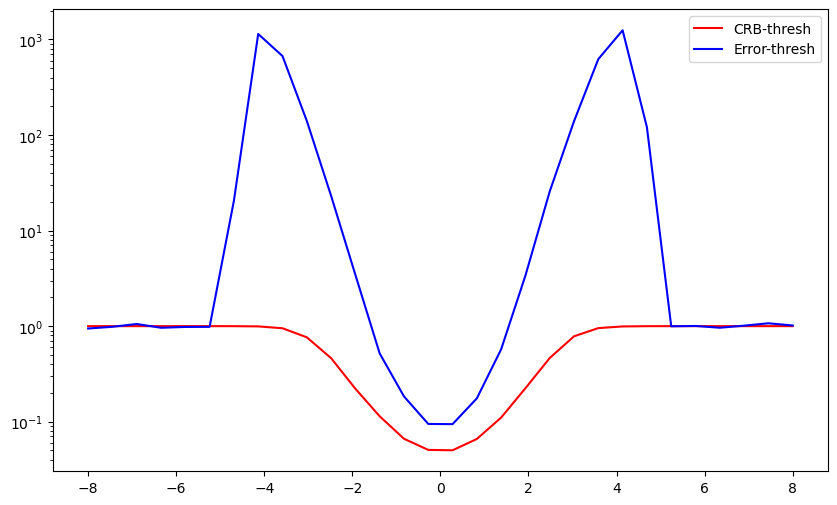

In [108]:
thresh_space = np.linspace(-8,8,30)
matrix_const = Matrix(na,nq)
# thresh_real = thresh_G(nq,matrix_const[1])[0]
# thresh_imag = thresh_G(nq,matrix_const[1])[1]
thresh_const = np.ones((M*nq, 1))

L_Estimator_numerical = [MSE_general_numerical(1,1, na,nq, matrix_const, sim,epsilon,thresh_space[i]*thresh_const,thresh_space[i]*thresh_const) for i in range(len(thresh_space))]
CRB1 = [CRB(1,1,na,nq,matrix_const,1,sim,thresh_space[i]*thresh_const,thresh_space[i]*thresh_const) for i in range(len(thresh_space))]
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(thresh_space, CRB1, color="red", label='CRB-thresh')
plt.plot(thresh_space, L_Estimator_numerical, color="blue", label='Error-thresh')

#plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.legend()
plt.show()

More Simulations:

In [105]:
M =1

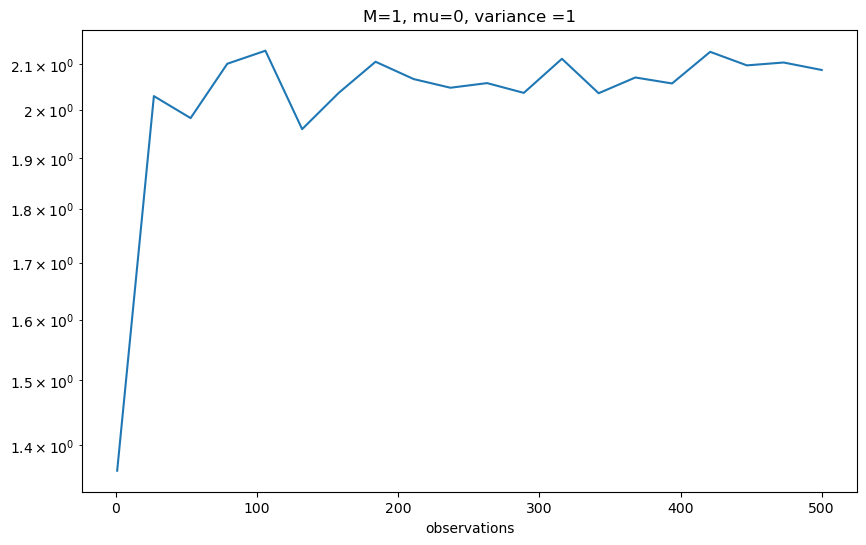

In [109]:
def CRB_observ(sigma, n,matrix, observ=sim):
    J1 = (rho_a*n/pow(sigma,2))*np.identity(M)
    teta_samp = samp_teta(observ)
    G = matrix
    g_teta = G@teta_samp
    G_normal = G/math.sqrt(rho_q*n)

    zeta_real = ((math.sqrt(2)/sigma)*(g_teta.real))
    zeta_im = ((math.sqrt(2)/sigma)*(g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply( norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d = np.mean(d_vec,1)# converge to 0.95 aprox

    # my_vector = [(rho_q*d[i])/(2*pow(sigma, 2))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    # J2 = np.sum(my_vector,axis=0)
    my_vector = [(d[i])/(2*pow(sigma, 2))*G[i].reshape(M,1).conjugate()*G[i].reshape(M,1).transpose() for  i in range(len(d))]
    J2 = np.sum(my_vector,axis=0)

    J2_3 = (1/(2*pow(sigma, 2)))*G.conjugate().transpose()@np.diag(d)@G
    J2_4 = ((rho_q*n)/(2*pow(sigma, 2)))*G_normal.conjugate().transpose()@np.diag(d)@G_normal

    return np.squeeze((M+J1)/(M+J2))#d
    #return np.squeeze((M+LA.norm(J1.real,"fro")/(M+LA.norm(J2_4.real,"fro"))))#d
#CRB_observ(1, 40,Matrix(40,40)[1], 100)
sim_observ = 100
n_list = np.linspace(1, 500, 20, dtype=int)
CRB = [CRB_observ(1,n_list[i],Matrix(n_list[i],n_list[i])[0],sim_observ) for i in range(len(n_list))]
# CRB_a = np.squeeze(np.array(CRB)[:,0])
# CRB_q = np.squeeze(np.array(CRB)[:,1])
# print("the diffrence is:{}".format(CRB_a[-1].real/CRB_q[-1].real))
# print("the diffrence is:{} dB".format(10*np.log10(CRB_a[-1]/CRB_q[-1]).real))
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(n_list,CRB)
# plt.plot(n_list,CRB_a , color="red", label='Analog BCRB')
# plt.plot(n_list,CRB_q , color="blue", label='Quantize BCRB')
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("observations")
# plt.legend()
# plt.legend()
plt.show()

C:\Users\Yaniv\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


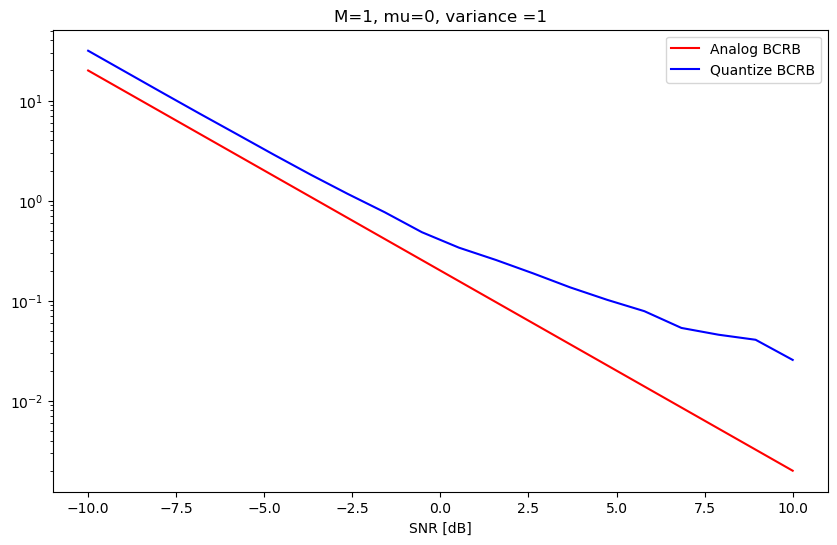

In [56]:
def CRB_SNR(sigma, n,matrix, observ=sim): #the importance of sigma_teta
    teta_samp = samp_teta(observ)
    g_teta = matrix @ teta_samp
    G_normal = matrix/math.sqrt(rho_q)

    zeta_real = ((math.sqrt(2)/sigma)*(g_teta.real))

    zeta_im = ((math.sqrt(2)/sigma)*(g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(norm.cdf(zeta_im), (norm.cdf(-zeta_im))))
    d = np.mean(d_vec,1)#(4/math.pi)*np.ones((np.shape(np.mean(d_vec, axis=1))))
    my_vector = [(rho_q*d[i])/(2*pow(sigma, 2))*G_normal[i].reshape(M,1).conjugate()*G_normal[i].reshape(M,1).transpose() for  i in range(len(d))]
    J2 = np.sum(my_vector,axis=0)
    J1 = (rho_a*n/pow(sigma, 2))*np.identity(M)

    return 1/J1,1/J2 #np.power(pdf_real, 2),norm.cdf(zeta_real),norm.cdf(-zeta_real) #np.mean(np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real)))),1)#1/J1,1/J2

sim_SNR = 100
new_sigma_space = np.logspace(-1,1,20)
n = 5
#CRB_SNR(0.01,n,Matrix(n,n)[0],sim_SNR)
CRB=[CRB_SNR(new_sigma_space[i],n,Matrix(n,n)[0],sim_SNR) for i in range(len(new_sigma_space))] #no quantize
CRB_a = np.squeeze(np.array(CRB)[:,0])
CRB_q = np.squeeze(np.array(CRB)[:,1])
#####################
fig = plt.figure(figsize=(10, 6))
plt.plot(10*np.log10(1/new_sigma_space),CRB_a , color="red", label='Analog BCRB')
plt.plot(10*np.log10(1/new_sigma_space),CRB_q , color="blue", label='Quantize BCRB')

#print("the diffrence is:{}".format(CRB_q[0].real/CRB_a[0].real))
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.show()

Till here

the diffrence is:4.540536084870265 dB


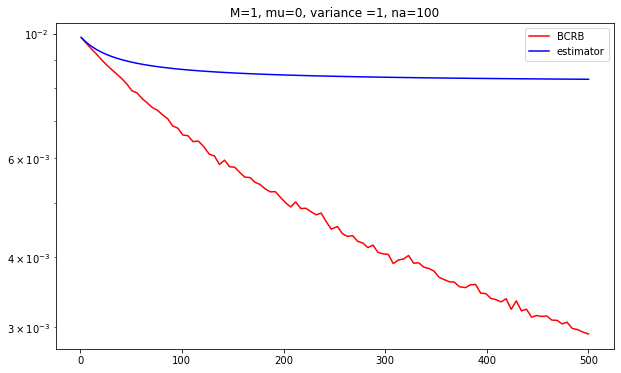

In [29]:
nq_list = np.linspace(1, 500, 100, dtype=int)
na=100
estimator = [MSE_zertothresh_analytic(1,1, na,nq_list[i]) for i in range(len(nq_list))]
CRB1 = [CRB(1,1,na,nq_list[i],Matrix(na,nq_list[i]),sim,0,0)[0] for i in range(len(nq_list))] #only quantize
######################
fig = plt.figure(figsize=(10, 6))
plt.plot(nq_list, CRB1, color="red", label='BCRB')
plt.plot(nq_list, estimator, color="blue", label='estimator')

print("the diffrence is:{} dB".format(10*np.log10(estimator[-1]/CRB1[-1])))
plt.title("M={}, mu={}, variance ={}, na=100".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.legend()
plt.legend()
plt.show()

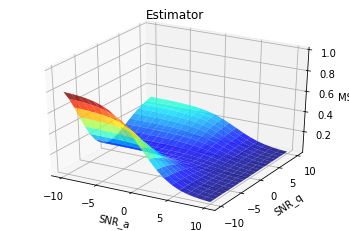

In [39]:
def MSE_zertothresh_analytic(sigma1,sigma2, n_a,n_q):
    alpha = (2 / math.pi) * np.arccos(rho_q / (rho_q + pow(sigma2, 2))) #np.arccos
    beta = ((1-alpha)/rho_q)-((2*rho_a*n_a)/(math.pi*(rho_q+pow(sigma2,2))*(rho_a*n_a+pow(sigma1,2))))
    first = (rho_a*n_a)/(rho_a*n_a+pow(sigma1, 2))
    second = (2*rho_q*n_q*pow(sigma1,4))/(math.pi*(rho_q+pow(sigma2, 2))*(alpha+beta*rho_q*n_q)*pow(rho_a*n_a+pow(sigma1, 2),2))
    return math.sqrt(M)*(1-first-second) #Frobenius  norm- not MSE, but relevant for CRB
# Create a meshgrid
x = np.logspace(-1,1,20)
y = np.logspace(-1,1,20)
X, Y = np.meshgrid(x, y)
# Evaluate the function on the meshgrid
Z = MSE_zertothresh_analytic(X,Y, 1,40)
# Create a 3-D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), Z, cmap='jet', alpha=0.8, edgecolor='none')
# Set labels and title
ax.set_xlabel('SNR_a')
ax.set_ylabel('SNR_q')
ax.set_zlabel('MSE')
ax.set_title('Estimator')

ax.set_xticks([-10,-5, 0,5, 10])
ax.set_yticks([-10,-5, 0,5, 10])
ax.set_zticks([0.2,0.4, 0.6,0.8, 1])

plt.show()

In [45]:
H,G = Matrix(na,nq) #Matrix is not argument
def CRB(sigma1,sigma2, n_a,n_q, observ=sim): #Matrix is not argument
    teta_samp = samp_teta(observ)
    g_teta = G @ teta_samp
    zeta_real = (math.sqrt(2) / sigma2 * (g_teta.real))
    zeta_im = (math.sqrt(2) / sigma2 * (g_teta.imag))
    pdf_real = norm.pdf(zeta_real)
    cdf_real = norm.cdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    cdf_im = norm.cdf(zeta_im)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(cdf_real, (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(cdf_im, (norm.cdf(-zeta_im))))
    d = np.mean(d_vec, axis=1)


    J2 =(1 /(2 * pow(sigma2, 2)))*(G.transpose().conjugate() @ np.diag(d) @ G)
    J1 = (1 + (rho_a * n_a / pow(sigma1, 2))) * np.identity(M)
    J = J1 + J2

    return LA.norm((LA.inv(J)).real,"fro")#, LA.norm((LA.inv(J1)).real,"fro"), LA.norm((LA.inv(J2)).real,"fro")


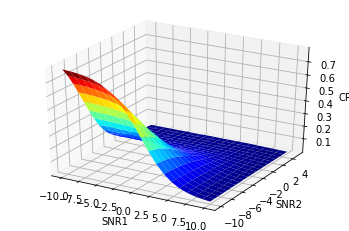

In [50]:
na=1
nq=40
# Evaluate the function on the meshgrid using np.vectorize
x = np.logspace(-1,1,20)
y = np.logspace(-0.5,1,20)
X, Y = np.meshgrid(x, y)
CRB_vectorized = np.vectorize(CRB)
CRB_vals = CRB_vectorized(X, Y,na,nq)

# Create a 3-D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), CRB_vals, cmap='jet')
# Set labels and title
ax.set_xlabel('SNR1')
ax.set_ylabel('SNR2')
ax.set_zlabel('CRB')
#ax.set_title('CRB vs. sigma1 and sigma2')

# Show the plot
plt.show()

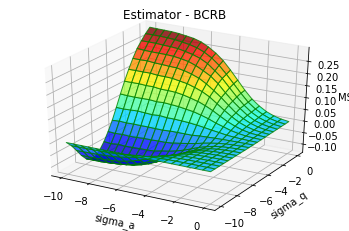

In [54]:
x = np.logspace(0,1,20)
y = np.logspace(0,1,20)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), Z-CRB_vals, cmap='jet', alpha=0.8, edgecolor='green')
#ax.plot_surface(10*np.log10(1/X), 10*np.log10(1/Y), CRB_vals, cmap='jet',edgecolor='red')
# Set labels and title
ax.set_xlabel('sigma_a')
ax.set_ylabel('sigma_q')
ax.set_zlabel('MSE')
ax.set_title('Estimator - BCRB')
plt.show()

In [ ]:
n_a = [1,2,1,2]
n_q = [40,40,100,100]
matrix_const1 = Matrix(n_a[0],n_q[0])

L_Estimator_analytic1 = [MSE_zertothresh_analytic(sigma_space[i],1, n_a[0],n_q[0]) for i in range(len(sigma_space))]
CRB1 = [CRB(sigma_space[i],1,n_a[0],n_q[0],matrix_const1)[0] for i in range(len(sigma_space))]


######################
fig = plt.figure(figsize=(10, 6))

plt.plot(10*np.log10(1/sigma_space), L_Estimator_analytic1,'--' ,label='n_a={}, n_q = {}'.format(n_a[i], n_q[i]))
plt.plot(10*np.log10(1/sigma_space), CRB1, label='n_a={}, n_q = {}, CRB'.format(n_a[i], n_q[i]))

plt.title("sigma2 is const".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.legend()
plt.show()